### Image codebook creation with SIFT

In [641]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import pickle
from itertools import chain

%matplotlib inline

In [611]:
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise IOError("Unable to open '%s'. Are you sure it's a valid image path?")
    return img

In [612]:
class RootSIFT(object):
    # From http://www.pyimagesearch.com/2015/04/13/implementing-rootsift-in-python-and-opencv/
    
    def __init__(self):
        # initialize the SIFT feature extractor
        self.extractor = cv2.DescriptorExtractor_create("SIFT")

    def compute(self, image, kps, eps=1e-7):
        # compute SIFT descriptors
        (kps, descs) = self.extractor.compute(image, kps)

        # if there are no keypoints or descriptors, return an empty tuple
        if len(kps) == 0:
            return ([], None)

        # apply the Hellinger kernel by first L1-normalizing and taking the
        # square-root
        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        #descs /= (np.linalg.norm(descs, axis=1, ord=2) + eps)

        # return a tuple of the keypoints and descriptors
        return (kps, descs)

In [613]:
def gen_sift_features(image_paths):
    """
    Generate SIFT features for images
    Parameters:
    -----------
    img_paths : list of lists
    Returns:
    --------
    img_descs : list of SIFT descriptors with same indicies as labeled_img_paths
    y : list of corresponding labels
    """
    image_df = pd.read_pickle('image_df.pickle')
    # img_keypoints = {}
    img_descs = []

    #print ('generating SIFT descriptors for %i images') % len(image_paths)

    for img_path in image_paths:
        img = read_image(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray, None)
        print (desc)
        # img_keypoints[img_path] = kp
        img_descs.append(desc)

    print ('SIFT descriptors generated.')

    y = np.array(image_paths)

    return img_descs, y



In [653]:
image_df1 = pd.read_pickle('image_df.pickle')
descs, y = gen_sift_features(image_df1.iloc[:,1])

In [421]:
#pickle descriptors
with open('descriptors.pkl', 'wb') as w:
    pickle.dump(descs, w)

In [423]:
descs[1].shape

(334, 128)

In [617]:
#Flatten descriptor array for clutstering
flattend_descs = list(chain.from_iterable(descs))
flattend_descs = np.array(flattend_descs)

In [619]:
flattend_descs.shape

(2698343, 128)

### Cluster images histograms to find optimum number of clusters

In [661]:
inertia_list = []
maxk = [50, 100, 500, 1000, 1500, 2000, 2500]
for k in maxk:
    model = MiniBatchKMeans(n_clusters=k, random_state=42, init_size=3*k)
    model.fit(flattend_descs)
    inertia_list.append(model.inertia_)

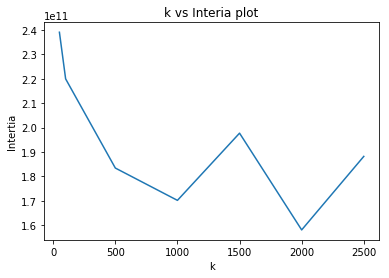

In [662]:
plt.plot(maxk,inertia_list)
plt.xlabel('k')
plt.ylabel('Intertia')
plt.title('k vs Interia plot')

### K-means clustering with n_clusters = 2000

In [419]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise
model = MiniBatchKMeans(n_clusters=2000, random_state=42, init_size=3*2000)
model.fit(flattend_descs) 

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=6000, max_iter=100, max_no_improvement=10,
        n_clusters=2000, n_init=3, random_state=42,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [201]:
mbk_means_cluster_centers = np.sort(model.cluster_centers_, axis=0)

In [427]:
mbk_means_cluster_centers.shape

(2000, 128)

In [620]:
#pickle cluster centers
with open('mbk_means_cluster_centers.pkl', 'wb') as w1:
    pickle.dump(mbk_means_cluster_centers, w1)

In [ ]:
# save the model to disk
#filename = 'clustering_model.sav'
#pickle.dump(model, open(filename, 'wb')

In [654]:
# Calculate Euclidean distance between cluster centers and descriptors for each image
# Create a histogram for codebook
from sklearn.metrics.pairwise import euclidean_distances
# Pairwise euclidean distances
hist_list = list()
for i in descs:
    ec = euclidean_distances(i, mbk_means_cluster_centers)

    # Closest cluster id and count
    closest_clust_id = np.argmin(ec, axis=1)

    cluster_id, word_count = np.unique(closest_clust_id, return_counts=True)

    # Dense matrix of word counts
    bag_of_nums = np.zeros(int(2000), dtype=np.int)
    bag_of_nums[cluster_id] = word_count            

    # Store the histogram in the proper row
    hist_list.append(pd.Series(bag_of_nums))

    hist_df = pd.concat(hist_list, axis=1).T
    hist_df = hist_df.reset_index()


In [655]:
# Pickle dataframe
hist_df.to_pickle('hist_df.pickle')

### Upload query/test image

In [657]:
test_image = cv2.imread('image1a_chanel.jpg')

In [659]:
# Generate keypoints and descriptors for test image
gray_test = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
sift_test = cv2.xfeatures2d.SIFT_create()
kp_test, desc_test = sift_test.detectAndCompute(gray_test, None)

In [626]:
desc_test.shape

(162, 128)

In [630]:
# Generate histogram for test image
hist_list_test = []
ec_test = euclidean_distances(desc_test, mbk_means_cluster_centers)

# Closest cluster id and count
closest_clust_id_test = np.argmin(ec_test, axis=1)

cluster_id_test, word_count_test = np.unique(closest_clust_id_test, return_counts=True)

# Dense matrix of word counts
bag_of_nums_test = np.zeros(int(2000), dtype=np.int)
bag_of_nums_test[cluster_id_test] = word_count_test        

# Store the histogram in the proper row
hist_list_test.append(pd.Series(bag_of_nums_test))

hist_df_test = pd.concat(hist_list_test, axis=1).T
hist_df_test = hist_df_test.reset_index()


In [631]:
hist_df_test.shape

(1, 2001)

In [632]:
# Function to calculate chi-squared distance between2 histograms
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])
        # return the chi-squared distance
    return d

In [660]:
# Calculate chi-squared distance between 
chi_dist = {}
for i in range(0,11962):
    chi_dist[i] = chi2_distance(hist_df.iloc[0, 1:], hist_df_test.iloc[i, 1:], eps = 1e-10)

In [636]:
# Sort distance list and pickle the top 200 
sorted_chi = sorted(chi_dist.items(), key=operator.itemgetter(1))
with open('top200.pkl', 'wb') as f:
    pickle.dump(sorted_chi[0:200], f)